In [2]:
import numpy as np
import matplotlib.pyplot as plt
from CRp_gamma import Phi_pp_gamma, velocity, integrate
# Takes CRp spectrum in MeV-1 cm-3 and returns gamma spectrum in erg cm-3 s-1
from CRe_gamma_radio import Phi_e_syn, Phi_e_rel_brem, Phi_e_IC
# Takes CRe spectrum in MeV-1 cm-3 and returns gamma spectrum in erg cm-3 s-1
from FeKalpha_CR import Phi_Fe_64_p, Phi_Fe_64_e
# Takes CR spectrum in MeV-1 cm-3 and returns flux in photons cm-2 s-1

## Parameters

General constants

In [3]:
pc = 3e18 #cm
kpc = 1e3 * pc 

MeV_to_erg = 1.602e-6 
m_p = 9.382e2 #MeV
m_e = 5.11e-1  #MeV
c = 2.998e10 #cm/s
hPlanck = 4.136e-21 #MeV/Hz
M_sol = 1.988e30 #kg
m_H = 1.674e-27 #kg
m_avg = 1.4 * m_H
sigma_sb = 3.539e1 #MeV cm-2 s-1 K-4

E_list = np.logspace(-13, 8, 100) #MeV

Cloud and shell parameters

In [4]:
ds = 2.2 * kpc

M_cl = 0.4 * M_sol
R_cl = 5.5e18 #cm (Miceli et al. 2016)
V_cl = (4 / 3) * np.pi * (R_cl ** 3)
n_cl = 0.5 #cm-3 (Miceli et al. 2016)
B_cl = 1e-2 #mG (few microG hence a maximum of 10 microG)
emi_pre_cl = V_cl / (4 * np.pi * (ds ** 2)) # cm

M_sh = 0.5 * M_sol
R_sh = 7.7 * pc #(Cristofari et al. 2019)
xf = 0.25 # volume-filling factor for SW limb
V_sh = (xf / 3) * np.pi * (R_sh ** 3) #cm3 (Cristofari et al. 2019)
n_sh = 0.035 #cm-3 (Giuffrida et al. 2022)
B_sh = 9e-2 #mG
emi_pre_sh = V_sh / (4 * np.pi * (ds ** 2)) # cm

Photon-field parameters

In [5]:
# T is K, w in MeV cm-3
T_CMB, w_CMB = 2.72, 0.261e-6
k_CMB = w_CMB * c / (sigma_sb * (T_CMB ** 4))
T_NIR, w_NIR = 30.0, 0.5e-6
k_NIR = w_NIR * c / (sigma_sb * (T_NIR ** 4))
T_FIR, w_FIR = 3000.0, 1.0e-6
k_FIR = w_FIR * c / (sigma_sb * (T_FIR ** 4))

## CR spectra

In [6]:
def Jp(p_p, del_p, A_p, p_pc):
    '''Gives no. of protons in MeV-3 cm-3'''
    return A_p * np.power(p_p, -(del_p+2)) * np.exp(- p_p / p_pc)


def Je(p_e, del_e, A_e, p_ec):
    '''Gives no. of electrons in MeV-3 cm-3'''
    return A_e * np.power(p_e, -(del_e+2)) * np.exp(- (p_e / p_ec)**2)


def J_CRp(T_p, del_p, A_p, p_pc):
    '''Gives no. of protons in MeV-1 cm-3 '''
    p_p = np.sqrt((T_p ** 2) + (2 * m_p * T_p))
    dp_on_dT = (T_p + m_p) / p_p
    return 4 * np.pi * (p_p ** 2) * Jp(p_p, del_p, A_p, p_pc) * dp_on_dT


def J_CRe(T_e, del_e, A_e, p_ec):
    '''Gives no. of electrons in MeV-1 cm-3 '''
    p_e = np.sqrt((T_e ** 2) + (2 * m_e * T_e))
    dp_on_dT = (T_e + m_e) / p_e
    return 4 * np.pi * (p_e ** 2) * Je(p_e, del_e, A_e, p_ec) * dp_on_dT

## Load multi-wavelength data

Import data

In [7]:
radio_data = np.genfromtxt(open("SN1006_data_radio.txt", "r"), delimiter=',') # in Hz and Jy Hz
xmm_nb_data = np.genfromtxt(open("SN1006_data_SW_XMM_narrowBand.txt", "r"), delimiter=',')  # in keV and photons cm-2 s-1 keV-1
fermi_data = np.genfromtxt(open("SN1006_data_SW_FERMI.txt", "r"), delimiter=',') # in GeV and erg cm-2 s-1
fermi_upper_data = np.genfromtxt(open("SN1006_data_SW_upper_FERMI_Acero2015.txt", "r"), delimiter=',') # in eV and erg cm-2 s-1
hess_data = np.genfromtxt(open("SN1006_data_SW_HESS.txt", "r"), delimiter=',') # in eV and erg cm-2 s-1

Convert to MeV and erg/cm2/s

In [8]:
Er, Phi_radio = radio_data[:, 0] * hPlanck, 1e-23 * radio_data[:, 1]
Exm_nb, Exm_nb_err, Phi_xmm_nb, Phi_xmm_nb_err = xmm_nb_data[:, 0] * 1e-3, xmm_nb_data[:, 1] * 1e-3, (xmm_nb_data[:, 2] * (xmm_nb_data[:, 0] ** 2)) * 1e-3 * MeV_to_erg, (xmm_nb_data[:, 3] * (xmm_nb_data[:, 0] ** 2)) * 1e-3 * MeV_to_erg
cond = np.where(np.logical_and(Phi_xmm_nb >= 0 , Phi_xmm_nb_err < Phi_xmm_nb))
Exm_nb, Exm_nb_err, Phi_xmm_nb, Phi_xmm_nb_err = Exm_nb[cond], Exm_nb_err[cond], Phi_xmm_nb[cond], Phi_xmm_nb_err[cond] 
Ef, Efm, Efp, Phi_fermi, Phi_fp, Phi_fm = fermi_data[:, 0] * 1e3, fermi_data[:, 1] * 1e3, fermi_data[:, 2] * 1e3, fermi_data[:, 3], fermi_data[:, 4], fermi_data[:, 5]
Efu, Phi_fermi_up = fermi_upper_data[:, 0] * 1e-6, fermi_upper_data[:, 1]
Eh, Phi_hp, Phi_hm = hess_data[:, 0] * 1e-6, hess_data[:, 1], hess_data[:, 2] 

X-ray continuum fit

In [9]:
A_x = 1.14e1 #MeV-1 cm-2 s-1
delta_x = 2.938

def dPhiXdE(E):
    return A_x * np.power(E * 1e3, - delta_x) * E #photons/MeV/cm2/s * MeV


In [10]:
E_fit_min, E_fit_max = 2e-3, 6e-3
integrate(dPhiXdE, E_fit_min, E_fit_max) * MeV_to_erg

6.536190466035723e-12

In [11]:
E_fit = np.logspace(np.log10(E_fit_min), np.log10(E_fit_max), 10)
Phi_xray_fit = np.array([dPhiXdE(E) * E * MeV_to_erg for E in E_fit])

Plot data

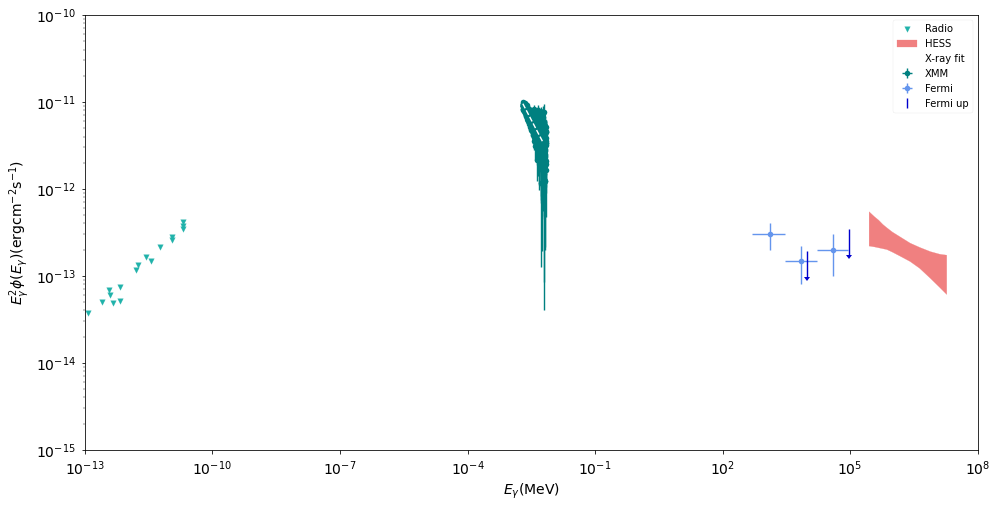

In [12]:
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14) 
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]
plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS')
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle='dashed', zorder=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

Fit with $\delta=2.0$

In [119]:
del_p_20, A_p_20, p_pc_20 = 2.0, 4e-5, 2e8
del_e_20, A_e_20, p_ec_20 = 2.0, 1e-9, 2e7

In [120]:
Phi_p_gamma_cl_20 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_20, A_p_20, p_pc_20, n_cl) for E in E_list])
Phi_p_gamma_sh_20 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_20, A_p_20, p_pc_20, n_sh) for E in E_list])
Phi_p_gamma_20 = np.nan_to_num(Phi_p_gamma_cl_20 + Phi_p_gamma_sh_20)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [84]:
Phi_e_IC_cl_20 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_20, A_e_20, p_ec_20, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_20, A_e_20, p_ec_20, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_20, A_e_20, p_ec_20, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_20 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_20, A_e_20, p_ec_20, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_20, A_e_20, p_ec_20, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_20, A_e_20, p_ec_20, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_20 = Phi_e_IC_cl_20 + Phi_e_IC_sh_20

Phi_e_brem_cl_20 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_20, A_e_20, p_ec_20, n_cl) for E in E_list])
Phi_e_brem_sh_20 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_20, A_e_20, p_ec_20, n_sh) for E in E_list])
Phi_e_brem_20 = Phi_e_brem_cl_20 + Phi_e_brem_sh_20

Phi_e_gamma_20 = Phi_e_brem_20 + Phi_e_IC_20

Phi_e_syn_cl_20 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_20, A_e_20, p_ec_20, B_cl) for E in E_list])
Phi_e_syn_sh_20 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_20, A_e_20, p_ec_20, B_sh) for E in E_list])
Phi_e_syn_20 = Phi_e_syn_cl_20 + Phi_e_syn_sh_20

In [121]:
Phi_total_gamma_20 = Phi_p_gamma_20 + Phi_e_gamma_20 

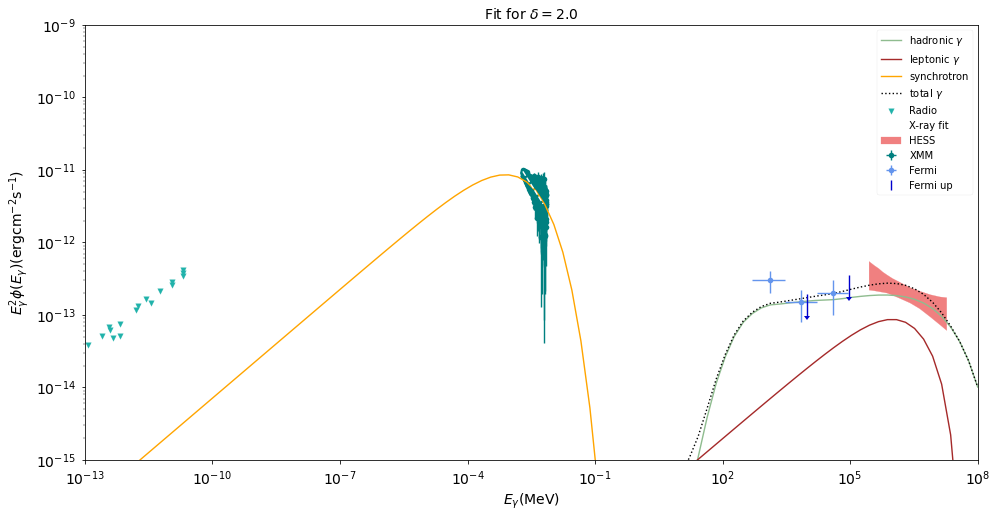

In [594]:
plt.style.use('seaborn-colorblind')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_20, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_20, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_20, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_20, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.0$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe20.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.1$

In [504]:
del_p_21, A_p_21, p_pc_21 = 2.1, 1.5e-4, 5e8
del_e_21, A_e_21, p_ec_21 = 2.1, 5e-9, 2e7

In [506]:
Phi_p_gamma_cl_21 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_21, A_p_21, p_pc_21, n_cl) for E in E_list])
Phi_p_gamma_sh_21 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_21, A_p_21, p_pc_21, n_sh) for E in E_list])
Phi_p_gamma_21 = np.nan_to_num(Phi_p_gamma_cl_21 + Phi_p_gamma_sh_21)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [505]:
Phi_e_IC_cl_21 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_21, A_e_21, p_ec_21, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_21, A_e_21, p_ec_21, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_21, A_e_21, p_ec_21, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_21 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_21, A_e_21, p_ec_21, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_21, A_e_21, p_ec_21, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_21, A_e_21, p_ec_21, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_21 = Phi_e_IC_cl_21 + Phi_e_IC_sh_21

Phi_e_brem_cl_21 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_21, A_e_21, p_ec_21, n_cl) for E in E_list])
Phi_e_brem_sh_21 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_21, A_e_21, p_ec_21, n_sh) for E in E_list])
Phi_e_brem_21 = Phi_e_brem_cl_21 + Phi_e_brem_sh_21

Phi_e_gamma_21 = Phi_e_brem_21 + Phi_e_IC_21

Phi_e_syn_cl_21 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_21, A_e_21, p_ec_21, B_cl) for E in E_list])
Phi_e_syn_sh_21 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_21, A_e_21, p_ec_21, B_sh) for E in E_list])
Phi_e_syn_21 = Phi_e_syn_cl_21 + Phi_e_syn_sh_21

In [507]:
Phi_total_gamma_21 = Phi_p_gamma_21 + Phi_e_gamma_21

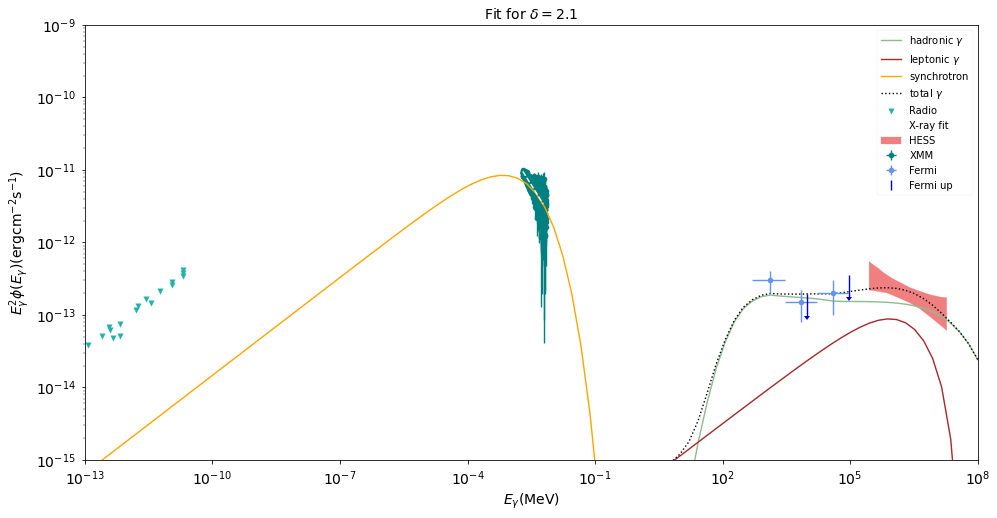

In [593]:
plt.style.use('seaborn-colorblind')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_21, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_21, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_21, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_21, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.1$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe21.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.2$

In [216]:
del_p_22, A_p_22, p_pc_22 = 2.2, 8e-4, 5e8
del_e_22, A_e_22, p_ec_22 = 2.2, 3e-8, 2e7

In [217]:
Phi_p_gamma_cl_22 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_22, A_p_22, p_pc_22, n_cl) for E in E_list])
Phi_p_gamma_sh_22 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_22, A_p_22, p_pc_22, n_sh) for E in E_list])
Phi_p_gamma_22 = np.nan_to_num(Phi_p_gamma_cl_22 + Phi_p_gamma_sh_22)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [177]:
Phi_e_IC_cl_22 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_22, A_e_22, p_ec_22, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_22, A_e_22, p_ec_22, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_22, A_e_22, p_ec_22, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_22 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_22, A_e_22, p_ec_22, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_22, A_e_22, p_ec_22, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_22, A_e_22, p_ec_22, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_22 = Phi_e_IC_cl_22 + Phi_e_IC_sh_22

Phi_e_brem_cl_22 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_22, A_e_22, p_ec_22, n_cl) for E in E_list])
Phi_e_brem_sh_22 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_22, A_e_22, p_ec_22, n_sh) for E in E_list])
Phi_e_brem_22 = Phi_e_brem_cl_22 + Phi_e_brem_sh_22

Phi_e_gamma_22 = Phi_e_brem_22 + Phi_e_IC_22

Phi_e_syn_cl_22 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_22, A_e_22, p_ec_22, B_cl) for E in E_list])
Phi_e_syn_sh_22 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_22, A_e_22, p_ec_22, B_sh) for E in E_list])
Phi_e_syn_22 = Phi_e_syn_cl_22 + Phi_e_syn_sh_22

In [218]:
Phi_total_gamma_22 = Phi_p_gamma_22 + Phi_e_gamma_22

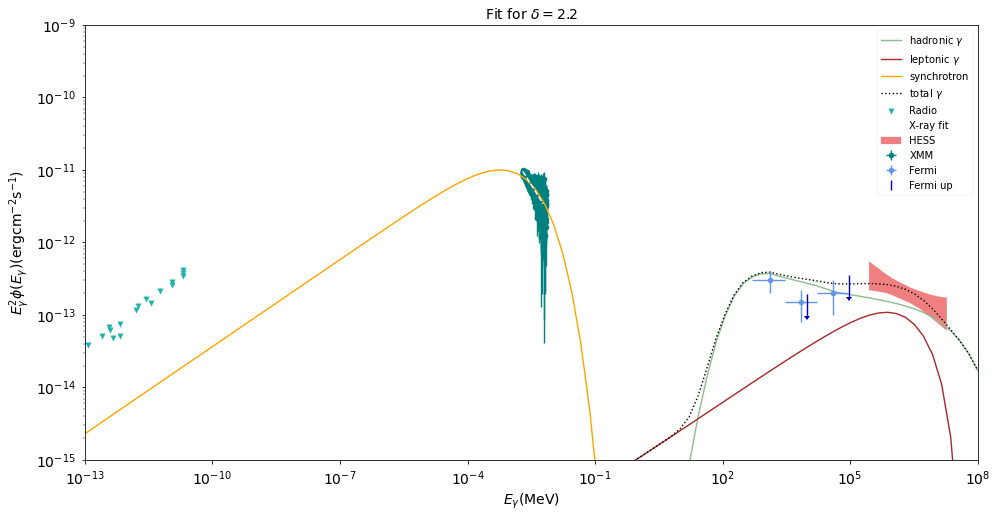

In [592]:
plt.style.use('seaborn-colorblind')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_22, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_22, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_22, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_22, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.2$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe22.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.3$

In [560]:
del_p_23, A_p_23, p_pc_23 = 2.3, 3e-3, 1e9
del_e_23, A_e_23, p_ec_23 = 2.3, 1.5e-7, 2e7

In [561]:
Phi_p_gamma_cl_23 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_23, A_p_23, p_pc_23, n_cl) for E in E_list])
Phi_p_gamma_sh_23 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_23, A_p_23, p_pc_23, n_sh) for E in E_list])
Phi_p_gamma_23 = np.nan_to_num(Phi_p_gamma_cl_23 + Phi_p_gamma_sh_23)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [562]:
Phi_e_IC_cl_23 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_23, A_e_23, p_ec_23, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_23, A_e_23, p_ec_23, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_23, A_e_23, p_ec_23, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_23 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_23, A_e_23, p_ec_23, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_23, A_e_23, p_ec_23, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_23, A_e_23, p_ec_23, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_23 = Phi_e_IC_cl_23 + Phi_e_IC_sh_23

Phi_e_brem_cl_23 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_23, A_e_23, p_ec_23, n_cl) for E in E_list])
Phi_e_brem_sh_23 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_23, A_e_23, p_ec_23, n_sh) for E in E_list])
Phi_e_brem_23 = Phi_e_brem_cl_23 + Phi_e_brem_sh_23

Phi_e_gamma_23 = Phi_e_brem_23 + Phi_e_IC_23

Phi_e_syn_cl_23 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_23, A_e_23, p_ec_23, B_cl) for E in E_list])
Phi_e_syn_sh_23 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_23, A_e_23, p_ec_23, B_sh) for E in E_list])
Phi_e_syn_23 = Phi_e_syn_cl_23 + Phi_e_syn_sh_23

In [563]:
Phi_total_gamma_23 = Phi_p_gamma_23 + Phi_e_gamma_23

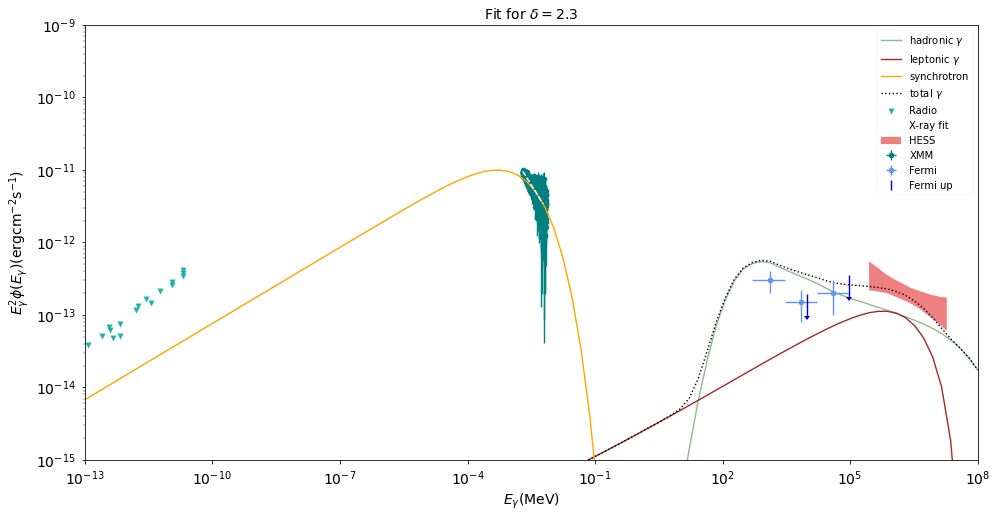

In [564]:
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_23, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_23, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_23, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_23, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.3$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe23.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.4$

In [338]:
del_p_24, A_p_24, p_pc_24 = 2.4, 5e-3, 1e9
del_e_24, A_e_24, p_ec_24 = 2.4, 1.5e-6, 1.5e7

In [339]:
Phi_p_gamma_cl_24 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_24, A_p_24, p_pc_24, n_cl) for E in E_list])
Phi_p_gamma_sh_24 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_24, A_p_24, p_pc_24, n_sh) for E in E_list])
Phi_p_gamma_24 = np.nan_to_num(Phi_p_gamma_cl_24 + Phi_p_gamma_sh_24)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [331]:
Phi_e_IC_cl_24 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_24, A_e_24, p_ec_24, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_24, A_e_24, p_ec_24, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_24, A_e_24, p_ec_24, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_24 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_24, A_e_24, p_ec_24, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_24, A_e_24, p_ec_24, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_24, A_e_24, p_ec_24, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_24 = Phi_e_IC_cl_24 + Phi_e_IC_sh_24

Phi_e_brem_cl_24 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_24, A_e_24, p_ec_24, n_cl) for E in E_list])
Phi_e_brem_sh_24 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_24, A_e_24, p_ec_24, n_sh) for E in E_list])
Phi_e_brem_24 = Phi_e_brem_cl_24 + Phi_e_brem_sh_24

Phi_e_gamma_24 = Phi_e_brem_24 + Phi_e_IC_24

Phi_e_syn_cl_24 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_24, A_e_24, p_ec_24, B_cl) for E in E_list])
Phi_e_syn_sh_24 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_24, A_e_24, p_ec_24, B_sh) for E in E_list])
Phi_e_syn_24 = Phi_e_syn_cl_24 + Phi_e_syn_sh_24

In [340]:
Phi_total_gamma_24 = Phi_p_gamma_24 + Phi_e_gamma_24

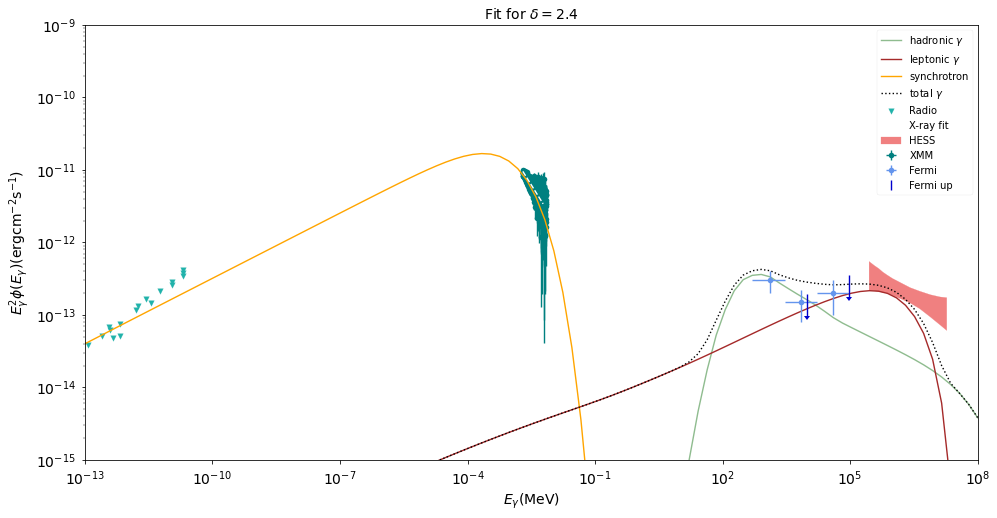

In [341]:
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_24, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_24, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_24, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_24, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.4$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe24.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.5$

In [583]:
del_p_25, A_p_25, p_pc_25 = 2.5, 1e-2, 1e9
del_e_25, A_e_25, p_ec_25 = 2.5, 5e-6, 2e7

In [584]:
Phi_p_gamma_cl_25 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_25, A_p_25, p_pc_25, n_cl) for E in E_list])
Phi_p_gamma_sh_25 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_25, A_p_25, p_pc_25, n_sh) for E in E_list])
Phi_p_gamma_25 = np.nan_to_num(Phi_p_gamma_cl_25 + Phi_p_gamma_sh_25)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [580]:
Phi_e_IC_cl_25 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_25, A_e_25, p_ec_25, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_25, A_e_25, p_ec_25, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_25, A_e_25, p_ec_25, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_25 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_25, A_e_25, p_ec_25, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_25, A_e_25, p_ec_25, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_25, A_e_25, p_ec_25, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_25 = Phi_e_IC_cl_25 + Phi_e_IC_sh_25

Phi_e_brem_cl_25 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_25, A_e_25, p_ec_25, n_cl) for E in E_list])
Phi_e_brem_sh_25 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_25, A_e_25, p_ec_25, n_sh) for E in E_list])
Phi_e_brem_25 = Phi_e_brem_cl_25 + Phi_e_brem_sh_25

Phi_e_gamma_25 = Phi_e_brem_25 + Phi_e_IC_25

Phi_e_syn_cl_25 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_25, A_e_25, p_ec_25, B_cl) for E in E_list])
Phi_e_syn_sh_25 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_25, A_e_25, p_ec_25, B_sh) for E in E_list])
Phi_e_syn_25 = Phi_e_syn_cl_25 + Phi_e_syn_sh_25

In [585]:
Phi_total_gamma_25 = Phi_p_gamma_25 + Phi_e_gamma_25

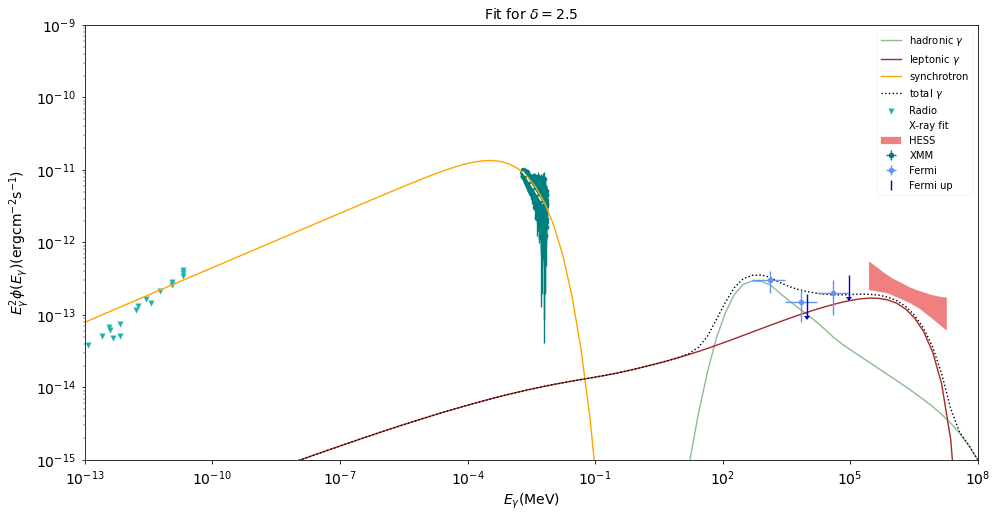

In [586]:
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_25, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_25, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_25, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_25, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.5$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe25.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.6$

In [377]:
del_p_26, A_p_26, p_pc_26 = 2.6, 5e-2, 1e9
del_e_26, A_e_26, p_ec_26 = 2.6, 2.5e-5, 2e7

In [374]:
Phi_p_gamma_cl_26 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_26, A_p_26, p_pc_26, n_cl) for E in E_list])
Phi_p_gamma_sh_26 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_26, A_p_26, p_pc_26, n_sh) for E in E_list])
Phi_p_gamma_26 = np.nan_to_num(Phi_p_gamma_cl_26 + Phi_p_gamma_sh_26)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [378]:
Phi_e_IC_cl_26 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_26, A_e_26, p_ec_26, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_26, A_e_26, p_ec_26, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_26, A_e_26, p_ec_26, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_26 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_26, A_e_26, p_ec_26, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_26, A_e_26, p_ec_26, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_26, A_e_26, p_ec_26, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_26 = Phi_e_IC_cl_26 + Phi_e_IC_sh_26

Phi_e_brem_cl_26 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_26, A_e_26, p_ec_26, n_cl) for E in E_list])
Phi_e_brem_sh_26 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_26, A_e_26, p_ec_26, n_sh) for E in E_list])
Phi_e_brem_26 = Phi_e_brem_cl_26 + Phi_e_brem_sh_26

Phi_e_gamma_26 = Phi_e_brem_26 + Phi_e_IC_26

Phi_e_syn_cl_26 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_26, A_e_26, p_ec_26, B_cl) for E in E_list])
Phi_e_syn_sh_26 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_26, A_e_26, p_ec_26, B_sh) for E in E_list])
Phi_e_syn_26 = Phi_e_syn_cl_26 + Phi_e_syn_sh_26

In [379]:
Phi_total_gamma_26 = Phi_p_gamma_26 + Phi_e_gamma_26

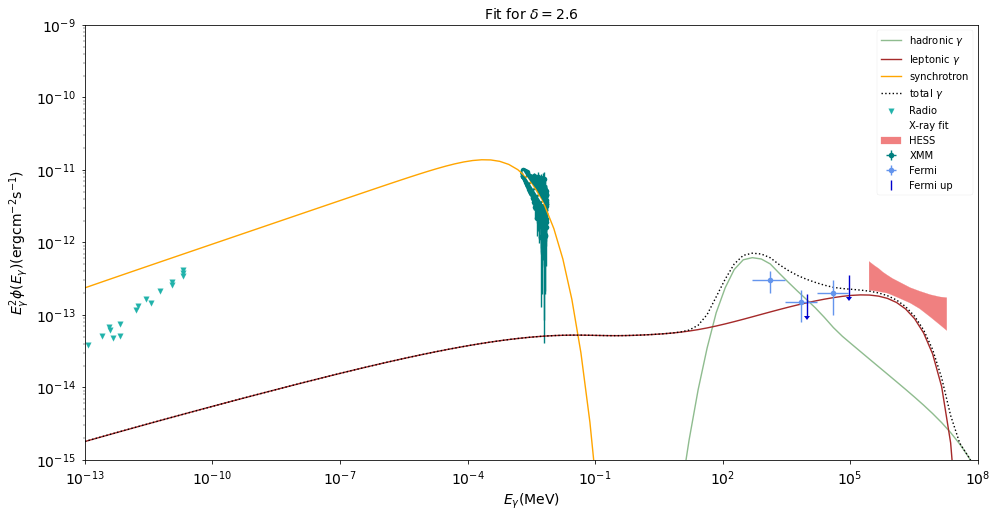

In [380]:
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_26, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_26, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_26, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_26, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.6$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe26.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fit with $\delta=2.8$

In [418]:
del_p_28, A_p_28, p_pc_28 = 2.8, 1e-1, 1e9
del_e_28, A_e_28, p_ec_28 = 2.8, 7e-4, 2e7

In [419]:
Phi_p_gamma_cl_28 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_28, A_p_28, p_pc_28, n_cl) for E in E_list])
Phi_p_gamma_sh_28 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_28, A_p_28, p_pc_28, n_sh) for E in E_list])
Phi_p_gamma_28 = np.nan_to_num(Phi_p_gamma_cl_28 + Phi_p_gamma_sh_28)

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


In [411]:
Phi_e_IC_cl_28 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_28, A_e_28, p_ec_28, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_28, A_e_28, p_ec_28, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_28, A_e_28, p_ec_28, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_sh_28 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_28, A_e_28, p_ec_28, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_28, A_e_28, p_ec_28, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_28, A_e_28, p_ec_28, T_FIR, k_FIR) for E in E_list])
Phi_e_IC_28 = Phi_e_IC_cl_28 + Phi_e_IC_sh_28

Phi_e_brem_cl_28 = emi_pre_cl * np.array([Phi_e_rel_brem(E, J_CRe, del_e_28, A_e_28, p_ec_28, n_cl) for E in E_list])
Phi_e_brem_sh_28 = emi_pre_sh * np.array([Phi_e_rel_brem(E, J_CRe, del_e_28, A_e_28, p_ec_28, n_sh) for E in E_list])
Phi_e_brem_28 = Phi_e_brem_cl_28 + Phi_e_brem_sh_28

Phi_e_gamma_28 = Phi_e_brem_28 + Phi_e_IC_28

Phi_e_syn_cl_28 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_28, A_e_28, p_ec_28, B_cl) for E in E_list])
Phi_e_syn_sh_28 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_28, A_e_28, p_ec_28, B_sh) for E in E_list])
Phi_e_syn_28 = Phi_e_syn_cl_28 + Phi_e_syn_sh_28

In [420]:
Phi_total_gamma_28 = Phi_p_gamma_28 + Phi_e_gamma_28

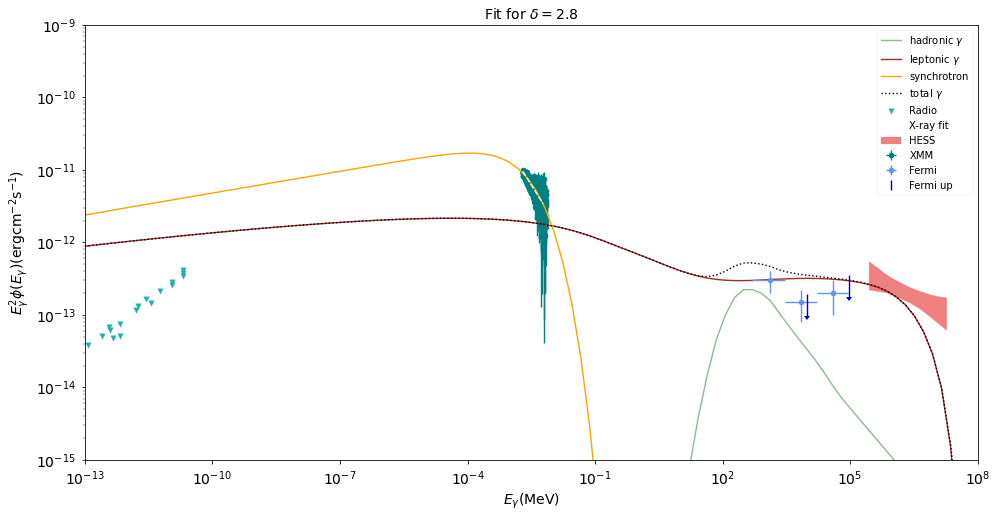

In [421]:
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)  
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [16, 8]

plt.plot(E_list, Phi_p_gamma_28, color='darkseagreen', label=r'hadronic $\gamma$')
plt.plot(E_list, Phi_e_gamma_28, color='brown', label=r'leptonic $\gamma$')
plt.plot(E_list, Phi_e_syn_28, color='orange', label='synchrotron')
plt.plot(E_list, Phi_total_gamma_28, color='black', label=r'total $\gamma$', linestyle='dotted')

plt.scatter(Er, Phi_radio, color='lightseagreen', marker='v', label='Radio')
plt.errorbar(Exm_nb, Phi_xmm_nb, yerr=Phi_xmm_nb_err, xerr=Exm_nb_err, color='teal', ecolor='teal', marker='o', linestyle='None', label='XMM', zorder=1)
plt.plot(E_fit, Phi_xray_fit, color='white', label='X-ray fit', linestyle="dashed", zorder=2)
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], color='cornflowerblue', ecolor='cornflowerblue', marker='o', linestyle='None', label='Fermi')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="mediumblue", uplims=True, label='Fermi up')
plt.fill_between(Eh, Phi_hm, Phi_hp, color='lightcoral', label='HESS', zorder=1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.title(r'Fit for $\delta=2.8$', fontdict={'fontsize':14})
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-9)
#plt.savefig('Fe28.png',format='png', dpi=600, bbox_inches = 'tight')
plt.show()

Fe K $\alpha$ line intensity

In [587]:
E_min = 10e-3 #MeV

Fe_64_p_20 = Phi_Fe_64_p(E_min, J_CRp, del_p_20, A_p_20, p_pc_20, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_20 = Phi_Fe_64_e(E_min, J_CRe, del_e_20, A_e_20, p_ec_20, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_21 = Phi_Fe_64_p(E_min, J_CRp, del_p_21, A_p_21, p_pc_21, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_21 = Phi_Fe_64_e(E_min, J_CRe, del_e_21, A_e_21, p_ec_21, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_22 = Phi_Fe_64_p(E_min, J_CRp, del_p_22, A_p_22, p_pc_22, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_22 = Phi_Fe_64_e(E_min, J_CRe, del_e_22, A_e_22, p_ec_22, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_23 = Phi_Fe_64_p(E_min, J_CRp, del_p_23, A_p_23, p_pc_23, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_23 = Phi_Fe_64_e(E_min, J_CRe, del_e_23, A_e_23, p_ec_23, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_24 = Phi_Fe_64_p(E_min, J_CRp, del_p_24, A_p_24, p_pc_24, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_24 = Phi_Fe_64_e(E_min, J_CRe, del_e_24, A_e_24, p_ec_24, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_25 = Phi_Fe_64_p(E_min, J_CRp, del_p_25, A_p_25, p_pc_25, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_25 = Phi_Fe_64_e(E_min, J_CRe, del_e_25, A_e_25, p_ec_25, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_26 = Phi_Fe_64_p(E_min, J_CRp, del_p_26, A_p_26, p_pc_26, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_26 = Phi_Fe_64_e(E_min, J_CRe, del_e_26, A_e_26, p_ec_26, M_cl) / (4 * np.pi * (ds ** 2))

Fe_64_p_28 = Phi_Fe_64_p(E_min, J_CRp, del_p_28, A_p_28, p_pc_28, M_cl) / (4 * np.pi * (ds ** 2))
Fe_64_e_28 = Phi_Fe_64_e(E_min, J_CRe, del_e_28, A_e_28, p_ec_28, M_cl) / (4 * np.pi * (ds ** 2))

In [588]:
print("Fe line for delta = ", del_e_20)
print(r'from CR protons:', Fe_64_p_20, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_20, 'cm-2 s-1')

print("Fe line for delta = ", del_e_21)
print(r'from CR protons:', Fe_64_p_21, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_21, 'cm-2 s-1')

print("Fe line for delta = ", del_e_22)
print(r'from CR protons:', Fe_64_p_22, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_22, 'cm-2 s-1')

print("Fe line for delta = ", del_e_23)
print(r'from CR protons:', Fe_64_p_23, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_23, 'cm-2 s-1')

print("Fe line for delta = ", del_e_24)
print(r'from CR protons:', Fe_64_p_24, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_24, 'cm-2 s-1')

print("Fe line for delta = ", del_e_25)
print(r'from CR protons:', Fe_64_p_25, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_25, 'cm-2 s-1')

print("Fe line for delta = ", del_e_26)
print(r'from CR protons:', Fe_64_p_26, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_26, 'cm-2 s-1')

print("Fe line for delta = ", del_e_28)
print(r'from CR protons:', Fe_64_p_28, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_28, 'cm-2 s-1')

Fe line for delta =  2.0
from CR protons: 2.582191734233515e-10 cm-2 s-1
from CR electrons: 5.134733382672469e-12 cm-2 s-1
Fe line for delta =  2.1
from CR protons: 5.582931957213649e-10 cm-2 s-1
from CR electrons: 2.8750404347820954e-11 cm-2 s-1
Fe line for delta =  2.2
from CR protons: 1.7317135287011548e-09 cm-2 s-1
from CR electrons: 1.952136062638355e-10 cm-2 s-1
Fe line for delta =  2.3
from CR protons: 3.805567346229848e-09 cm-2 s-1
from CR electrons: 1.1141271659723802e-09 cm-2 s-1
Fe line for delta =  2.4
from CR protons: 3.742061514384278e-09 cm-2 s-1
from CR electrons: 1.2809014876875331e-08 cm-2 s-1
Fe line for delta =  2.5
from CR protons: 4.442501334154639e-09 cm-2 s-1
from CR electrons: 4.938902826780193e-08 cm-2 s-1
Fe line for delta =  2.6
from CR protons: 1.3258635794298699e-08 cm-2 s-1
from CR electrons: 2.871587413436564e-07 cm-2 s-1
Fe line for delta =  2.8
from CR protons: 9.590988253220007e-09 cm-2 s-1
from CR electrons: 1.1016819479864391e-05 cm-2 s-1


In [589]:
Fe_64_obs = 1.9e-7 

M_cl_p_20 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_20, A_p_20, p_pc_20, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_20 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_20, A_e_20, p_ec_20, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_21 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_21, A_p_21, p_pc_21, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_21 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_21, A_e_21, p_ec_21, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_22 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_22, A_p_22, p_pc_22, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_22 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_22, A_e_22, p_ec_22, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_23 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_23, A_p_23, p_pc_23, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_23 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_23, A_e_23, p_ec_23, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_24 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_24, A_p_24, p_pc_24, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_24 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_24, A_e_24, p_ec_24, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_25 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_25, A_p_25, p_pc_25, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_25 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_25, A_e_25, p_ec_25, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_26 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_26, A_p_26, p_pc_26, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_26 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_26, A_e_26, p_ec_26, 1) / (4 * np.pi * (ds ** 2)))

M_cl_p_28 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_28, A_p_28, p_pc_28, 1) / (4 * np.pi * (ds ** 2)))
M_cl_e_28 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_28, A_e_28, p_ec_28, 1) / (4 * np.pi * (ds ** 2)))

In [591]:
print("Fe line for delta = ", del_e_20)
print(r'from CR protons:', M_cl_p_20 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_20 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_21)
print(r'from CR protons:', M_cl_p_21 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_21 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_22)
print(r'from CR protons:', M_cl_p_22 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_22 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_23)
print(r'from CR protons:', M_cl_p_23 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_23 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_24)
print(r'from CR protons:', M_cl_p_24 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_24 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_25)
print(r'from CR protons:', M_cl_p_25 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_25 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_26)
print(r'from CR protons:', M_cl_p_26 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_26 / M_sol, 'M_sol')

print("Fe line for delta = ", del_e_28)
print(r'from CR protons:', M_cl_p_28 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_28 / M_sol, 'M_sol')

Fe line for delta =  2.0
from CR protons: 294.32361273729913 M_sol
from CR electrons: 14801.157983483137 M_sol
Fe line for delta =  2.1
from CR protons: 136.12918907564543 M_sol
from CR electrons: 2643.4410827950733 M_sol
Fe line for delta =  2.2
from CR protons: 43.887166520551844 M_sol
from CR electrons: 389.3171252483514 M_sol
Fe line for delta =  2.3
from CR protons: 19.97074104477293 M_sol
from CR electrons: 68.21483428569776 M_sol
Fe line for delta =  2.4
from CR protons: 20.30966078667071 M_sol
from CR electrons: 5.933321237467378 M_sol
Fe line for delta =  2.5
from CR protons: 17.10747938682656 M_sol
from CR electrons: 1.5388033064328683 M_sol
Fe line for delta =  2.6
from CR protons: 5.732113105684712 M_sol
from CR electrons: 0.2646619763145125 M_sol
Fe line for delta =  2.8
from CR protons: 7.924105211419097 M_sol
from CR electrons: 0.006898542736304825 M_sol
